# Pipeline Factory
In this notebook you'll know how to create pipelines for:
* train model to digits classification
* load pretrained model to predict digits
* train model to bounding box regression
* load pretrained model to predict coordinates of bounding box
* load two pretrained models and predict digits

This is a set of the most simple and standard pipelines, to solve the problem of finding numbers on meters. Therefore, it was decided to merge these pipelines into one class called __Pipeline Factory__.

The implementation of the __Pipeline Factory__ you can find in [pipelines]() and examples of using methods of this class can be found here.

In [1]:
import sys

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

sys.path.append('..')
from meters.batch import MeterBatch
from meters.pipelines import PipelineFactory
from meters.dataset import B,V,F, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet101, DenseNet121, VGG19, MobileNet_v2, TFModel

In [2]:
def add_bb(img, bb, c, width=3):
    """Surrounds bounding box with given coordinates.
    
    Parameters
    ----------
    img : array
        image
    bb : array with len 4
        coordinates of bounding box
    c : int
        color
    width : int, optional
        Thickness of the bounding box.
    
    Returns
    -------
    image with a circled bounding box.
        """
    lc, lr, w, h = bb.astype(np.int)
    im_height = img.shape[0] - 1
    im_width = img.shape[1] - 1
    for i in range(width):
        img[min(im_height,lr):min(im_height,lr)+i, min(im_width,lc):min(im_width,lc+w),:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc):min(im_width,lc)+i,:]=c
        img[min(im_height,lr):min(im_height,lr+h), min(im_width,lc+w):min(im_width,lc+w)+i,:]=c
        img[min(im_height,lr+h):min(im_height,lr+h)+i, min(im_width,lc):min(im_width,lc+w),:]=c
    return img

In [3]:
def calculate_accuracy(labels, predictions):
    """Calculate accuracy
    
    Parameters
    ----------
    labels : array
        real answers
    predictions : array
        model predictions
    
    Returns
    -------
    accuracy
    """
    predictions = np.argmax(predictions, axis=-1)
    accuracy = len(np.where(predictions == labels)[0])/len(labels)
    return accuracy

First create an instance of the Pipeline Factory class

In [4]:
pf = PipelineFactory()

Secondly, an instance of the dataset is created in which the indexes are the names of the pictures intended for learning and predicting.

In [5]:
src = 'path/to/images/'
fileindex = FilesIndex(path=src + '*.png', no_ext=True)
dset = Dataset(fileindex, batch_class=MeterBatch)
dset.cv_split()

Let's load and look at the images. In this we will benefit from two functions from Pipeline Factory:
* __load_all__ - function created a pipeline which load all data, such as images, labels and coordinates.
* __make_digits__ - function created a pipeline whitch cropped separate digits from images.

For the parameters for these functions, see the [documentation]().

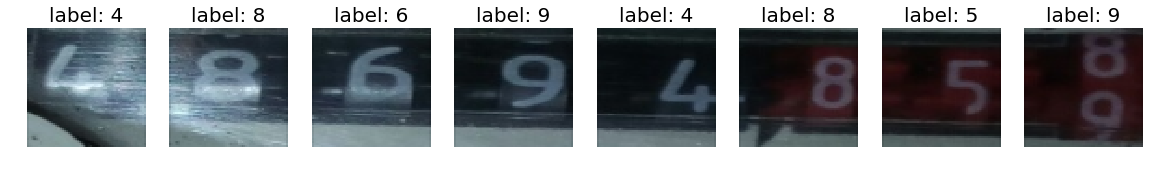

In [6]:
src = 'path/to/data/'
ppl_digits = pf.load_all(src=src) + pf.make_digits(shape=(64, 64))
ppl_digits = ppl_digits << dset.train
batch = ppl_digits.next_batch(1)

_, axis = plt.subplots(1, 8, figsize=(20, 10))
axis = axis.reshape(-1)
for i in range(8):
    axis[i].imshow(batch.images[i]/255)
    axis[i].set_title('label: {}'.format(batch.labels[i]), fontsize=20)
    axis[i].grid()
    axis[i].axis('off')
plt.show()

# Train on digits
Create a pipeline that will train the model to recognize only the numbers. The input images are the cut images with numbers as shown above.

All the training pipelines take on the two parameters __pipline_config__ and __model_config__.

* __Pipeline config__ this is a dictionary that allows you to configure the Pipeline itself. 
* __Model config__ this is a dictionary that allows you to configure the model.

You can read all the parameters in the [documentation]().

For train the model we will use the method named __train_to_digits__. About which you can read in the [docs]().

In [7]:
train_ppl = pf.train_to_digits(src='path/to/data, 
                               shape=(64,32),
                               pipeline_config={'model': VGG19,
                                        'model_name': 'digits',
                                        'batch_size': 10,
                                        'n_epochs': None,
                                        'save': True})

Let's train the model

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


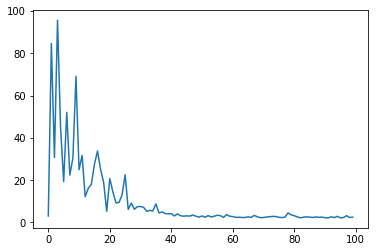

In [8]:
ppl_new_train = dset.train>>train_ppl
for i in tqdm(range(100)):
    batch = ppl_new_train.next_batch()
plt.plot(ppl_new_train.get_variable('current_loss'))

After training it is necessary to check the quality. To do this, we'll create a pipeline for the prediction.

# Predict digits
There are two ways to load a model for prediction.

1. Load saved model.
2. Load model from pretrained pipeline.

Let's see how to load the saved model. For model prediction use method __predict_digits__. About which you can read in the [docs]().

In [9]:
load_pred_ppl = pf.predict_digits(shape=(64, 32),
                                  src='path/to/data', 
                                  pipeline_config={'model_name':'VGG7',
                                                   'model':'./VGG7/'})

INFO:tensorflow:Restoring parameters from ./VGG7/model-900


Load the data and measure the quality of training

In [10]:
load_pred_ppl = dset.train>>load_pred_ppl
batch = load_pred_ppl.next_batch(100)

accuracy = calculate_accuracy(batch.labels, load_pred_ppl.get_variable('predictions'))
print('Total accuracy: ', accuracy)

Total accuracy:  0.99125


Now we will consider the second method. In this method, we take the model from the pretrained papipline

In [11]:
config = {'model_name': 'digits',
         'model': ppl_new_train}
pred_ppl = pf.predict_digits(shape=(64, 32), src='path/to/data', pipeline_config=config)

As well as the last time, we load the data and measure the quality of training

In [12]:
pred_ppl = dset.train>>pred_ppl
batch = pred_ppl.next_batch(100)

accuracy = calculate_accuracy(batch.labels, np.array(pred_ppl.get_variable('predictions')))
print('Total accuracy: ', accuracy)

Total accuracy:  0.0825


# Train to coordinates

Now let's training the model for the prediction of coordinates. In this case we use the method named __train_to_coordinates__. About which you can read in the [docs]().

In the beginning we will create configurations for the payline and model.

In [13]:
src = '.'
batch_size = 10

config = {'model': MobileNet_v2,
          'model_name': 'model',
          'batch_size': batch_size,
}

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True

model_config = {
     'session' : {'config' : session_config},
     'body': {'width_factor' : 1},
     'inputs' : {'images': {'shape': (120, 120, 3),
                            'data_format': 'channels_last'},
                 'labels': {'name': 'targets', 'shape' : (4,)}},
     'loss' : {'name' : 'huber', 'delta' : 1},
     'decay' : {'name':"exp", "decay_rate" : 0.95, 'learning_rate' : 1.,\
                "decay_steps" : 10, 'staircase' : True},
     'optimizer': {'name' : 'Momentum', 'momentum' : 0.99, 'use_nesterov' : True},
     'input_block/inputs' : 'images'}

Then a pipeline with the specified configuration will created.

In [14]:
ppl = pf.train_to_coordinates('path/to/data', pipeline_config=config, model_config=model_config)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Let's train the model and draw a plot of the loss values during the training.

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


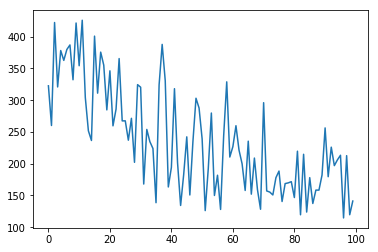

In [15]:
ppl_new = dset.train>>ppl
for i in tqdm(range(100)):
    batch = ppl_new.next_batch()
plt.plot(ppl_new.get_variable('current_loss'))

As last time, we will create a pipeline to check the quality of the model.

# Prediction of the bounding box

After training the model predict the coordinates of the bounding box, we will check the quality using the method [__predict_coordinates__]() from Pipeline Factory class. Like the configuration, we have the ability to specify the names of the components that are used during the prediction. For the transfer of component names, the dictionary named __components__, where keys key is the standard component name and values is the new name of the component.

In [16]:
components = {'coordinates': 'pred_coordinates'}
config.update(model_name='model', model='path/to/model')
ppl = pf.predict_coordinates(src='path/to/data', components=components, pipeline_config=config)

INFO:tensorflow:Restoring parameters from ./resnet_for_the_poor_last_epoch_iou69/model-41744


Let's train the model

In [17]:
ppl_pred_new = dset.train>>ppl
for i in range(1):
    batch = ppl_pred_new.next_batch()

For quality control, let's plot a random image with the predicted baonding box.

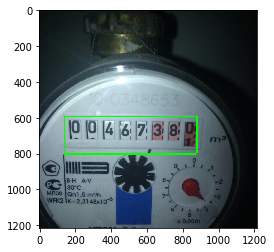

In [18]:
bb = ppl_pred_new.get_variable('predictions')[0][3]
plt.imshow(add_bb(batch.images[3]/255, bb, c=(0, 1, 0), width=10))

# Full predicton

Finally, consider the function for predicting digits based on a meter images. This prediction is performed in 2 stages, first we predict the coordinates of the bounding box, then this bounding box is divided into separate digits and the individual digits are predicted.

Therefore, in this function there are 2 configuration dicts and components dicts, separate for each of the predictions.

In [19]:
ppl_config_coord = {
    'model_name': 'model',
    'model': 'path/to/model/'
}
ppl_config_digits = {
    'model_name': 'VGG7',
    'model': load_pred_ppl,
    'batch_size': 2
}
components_coord = {'coordinates': 'pred_coordinates'}
components_digits = {'coordinates': 'pred_coordinates'}

ppl = pf.full_prediction(src='path/to/images', 
                         components_coord=components_coord,
                         pipeline_config_coord=ppl_config_coord,
                         components_digits=components_digits,
                         pipeline_config_digits = ppl_config_digits)

INFO:tensorflow:Restoring parameters from ./resnet_for_the_poor_last_epoch_iou69/model-41744


let's make a prediction

In [20]:
ppl_new = dset.test>>ppl
batch = ppl_new.next_batch()

Let's see how the bounding box was predicted and how according to the predicted bounding box the numbers were predicted.

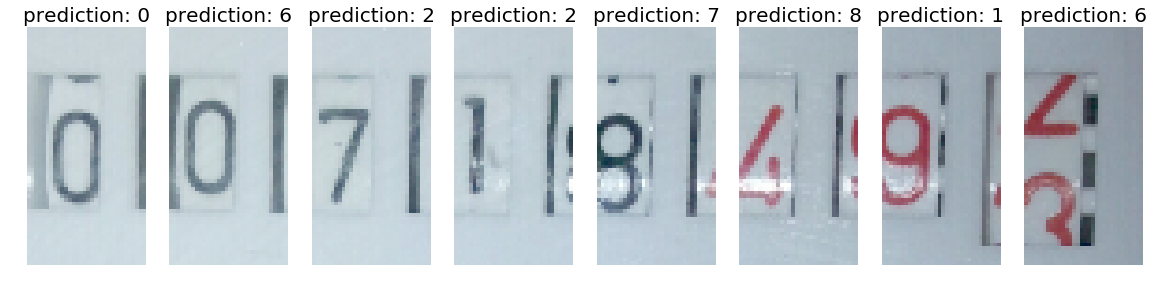

In [21]:
_, axis = plt.subplots(1, 8, figsize=(20, 10))
axis = axis.reshape(-1)
for i in range(8):
    axis[i].imshow(batch.images[i])
    preds = np.argmax(ppl_new.get_variable('predictions')[-1][-i], axis=-1)
    axis[i].set_title('prediction: {}'.format(preds), fontsize=20)
    axis[i].axis('off')
plt.show()

# Conclusions: 
* Now you know how to train model and predict in one line of code by using the Pipeline Factory class.